In [24]:
%%capture
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import keras as k
from keras.layers import Dense, LSTMCell, LSTM
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = True

# 1. Carga de data.
**********************************

In [25]:
df = pd.read_pickle('el_df.pkl')
date_time = pd.to_datetime(df.index, format = '%Y-%m-%d %H:%M:%S')
df = df.reset_index()
df.pop('Fecha')
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


Veamos el factor temporal, notemos si es posible ver una recurrecia en los datos en torno al tiempo.

Text(0.5, 1.0, 'Gráfico recurrencia en el tiempo - 5 días.')

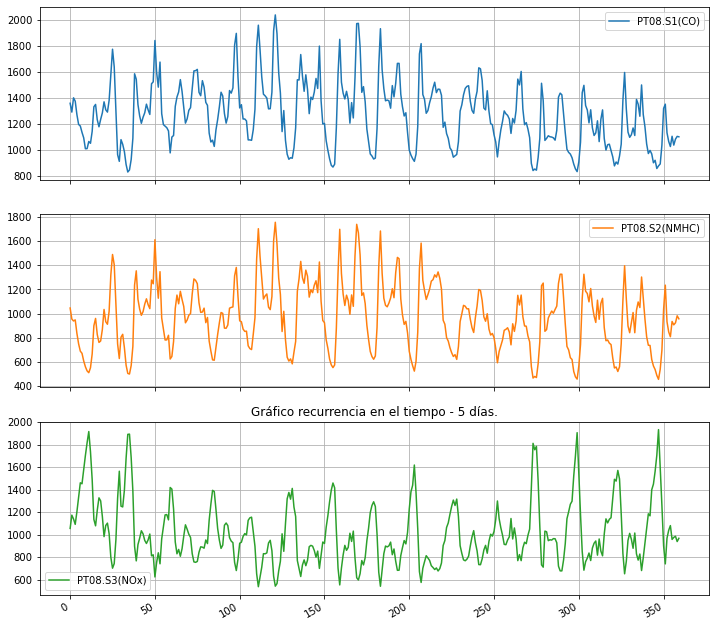

In [26]:
feat = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)']
plot_feat = df[feat][:360]
plot_feat.index = df.index[:360]
_ = plot_feat.plot(subplots=True)
plt.title('Gráfico recurrencia en el tiempo - 5 días.')

Variable anterior
****************

In [27]:
df_new = {col: list(df[col][24:-24]) for col in df.columns}
L = len(df['PT08.S1(CO)'][24:-24])
print(L)
for i in range(24):
  df_new['PT08 -'+str(i+1)] = list(df['PT08.S1(CO)'][24-(i+1):][:L])

9309


In [28]:
df_new = pd.DataFrame(df_new)
df = df_new
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,...,PT08 -15,PT08 -16,PT08 -17,PT08 -18,PT08 -19,PT08 -20,PT08 -21,PT08 -22,PT08 -23,PT08 -24
0,1581.0,1319.0,799.0,2083.0,1409.0,10.3,64.2,0.8065,1383.0,1292.0,...,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0,1360.0
1,1776.0,1488.0,702.0,2333.0,1704.0,9.7,69.3,0.8319,1581.0,1383.0,...,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0,1292.0
2,1640.0,1404.0,743.0,2191.0,1654.0,9.6,67.8,0.8133,1776.0,1581.0,...,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0,1402.0
3,1313.0,1076.0,957.0,1707.0,1285.0,9.1,64.0,0.7419,1640.0,1776.0,...,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0,1376.0
4,965.0,749.0,1325.0,1333.0,821.0,8.2,63.4,0.6905,1313.0,1640.0,...,1144.0,1052.0,1066.0,1011.0,1010.0,1094.0,1136.0,1185.0,1197.0,1272.0


In [29]:
#Base polinomial de orden 2
for col in df.columns:
  df[col + ' ^2'] = df[col]**2

In [30]:
# # Agregar Output
# for i in range(24):
#   df2['out-'+str(i+1)] = list(df['PT08.S1(CO)'][24+(i+1):][:L])

df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,...,PT08 -15 ^2,PT08 -16 ^2,PT08 -17 ^2,PT08 -18 ^2,PT08 -19 ^2,PT08 -20 ^2,PT08 -21 ^2,PT08 -22 ^2,PT08 -23 ^2,PT08 -24 ^2
0,1581.0,1319.0,799.0,2083.0,1409.0,10.3,64.2,0.8065,1383.0,1292.0,...,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0,1669264.0,1849600.0
1,1776.0,1488.0,702.0,2333.0,1704.0,9.7,69.3,0.8319,1581.0,1383.0,...,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0,1669264.0
2,1640.0,1404.0,743.0,2191.0,1654.0,9.6,67.8,0.8133,1776.0,1581.0,...,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0,1965604.0
3,1313.0,1076.0,957.0,1707.0,1285.0,9.1,64.0,0.7419,1640.0,1776.0,...,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0,1893376.0
4,965.0,749.0,1325.0,1333.0,821.0,8.2,63.4,0.6905,1313.0,1640.0,...,1308736.0,1106704.0,1136356.0,1022121.0,1020100.0,1196836.0,1290496.0,1404225.0,1432809.0,1617984.0


# Separación de la data.
*******************************
Ocuparemos los siguientes porcentajes para separar la base de datos: 70% para el subconjunto de entrenamiento, 20% para el subconjunto de validación y 10% para el subconjunto de testeo. Cabe aclarar que esta sample será ordenado, para poder considerar el paso temporal entre una observación y la siguiente.

In [31]:
n = np.shape(df)[0]
trainset = df[0:int(0.7*n)]
valset = df[int(0.7*n):int(0.9*n)]
testset = df[int(0.9*n):]
num_features = df.shape[1]
num_features

64

### Normalización de los datos.

In [32]:
df.columns

Index(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'PT08 -1', 'PT08 -2', 'PT08 -3',
       'PT08 -4', 'PT08 -5', 'PT08 -6', 'PT08 -7', 'PT08 -8', 'PT08 -9',
       'PT08 -10', 'PT08 -11', 'PT08 -12', 'PT08 -13', 'PT08 -14', 'PT08 -15',
       'PT08 -16', 'PT08 -17', 'PT08 -18', 'PT08 -19', 'PT08 -20', 'PT08 -21',
       'PT08 -22', 'PT08 -23', 'PT08 -24', 'PT08.S1(CO) ^2',
       'PT08.S2(NMHC) ^2', 'PT08.S3(NOx) ^2', 'PT08.S4(NO2) ^2',
       'PT08.S5(O3) ^2', 'T ^2', 'RH ^2', 'AH ^2', 'PT08 -1 ^2', 'PT08 -2 ^2',
       'PT08 -3 ^2', 'PT08 -4 ^2', 'PT08 -5 ^2', 'PT08 -6 ^2', 'PT08 -7 ^2',
       'PT08 -8 ^2', 'PT08 -9 ^2', 'PT08 -10 ^2', 'PT08 -11 ^2', 'PT08 -12 ^2',
       'PT08 -13 ^2', 'PT08 -14 ^2', 'PT08 -15 ^2', 'PT08 -16 ^2',
       'PT08 -17 ^2', 'PT08 -18 ^2', 'PT08 -19 ^2', 'PT08 -20 ^2',
       'PT08 -21 ^2', 'PT08 -22 ^2', 'PT08 -23 ^2', 'PT08 -24 ^2'],
      dtype='object')

In [33]:
media = trainset.mean()
std = trainset.std()

trainset = (trainset-media)/std
valset = (valset-media)/std
testset = (testset-media)/std

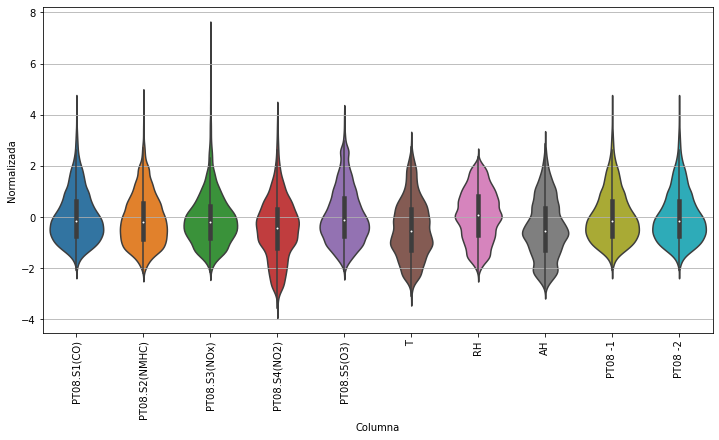

In [34]:
df_std = (df[df.columns[:10]] - media[:10]) / std[:10]
# df_std = df[df.columns[:10]]
df_std = df_std.melt(var_name='Columna', value_name='Normalizada')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Columna', y='Normalizada', data=df_std)
_ = ax.set_xticklabels(df[:10].keys(), rotation=90)

In [35]:
trainset.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08 -1,PT08 -2,...,PT08 -15 ^2,PT08 -16 ^2,PT08 -17 ^2,PT08 -18 ^2,PT08 -19 ^2,PT08 -20 ^2,PT08 -21 ^2,PT08 -22 ^2,PT08 -23 ^2,PT08 -24 ^2
0,2.208743,1.320695,-0.220999,1.728524,1.067801,-1.498649,0.954211,-1.048199,1.301705,0.884853,...,-0.450730,-0.111838,0.067815,0.285991,0.341000,0.696128,1.223977,1.362162,0.793813,1.139175
1,3.101620,1.953441,-0.608856,2.591454,1.850954,-1.576705,1.246428,-0.976214,2.208262,1.301479,...,-0.446856,-0.450630,-0.111734,0.067949,0.286192,0.341049,0.695955,1.223693,1.361919,0.793470
2,2.478896,1.638940,-0.444917,2.101310,1.718217,-1.589714,1.160482,-1.028927,3.101083,2.207982,...,-0.227881,-0.446756,-0.450542,-0.111616,0.068120,0.286239,0.340910,0.695735,1.223452,1.361555
3,0.981610,0.410889,0.410769,0.430678,0.738611,-1.654760,0.942751,-1.231277,2.478398,3.100750,...,-0.284720,-0.227775,-0.446668,-0.450454,-0.111470,0.068160,0.286104,0.340734,0.695505,1.223094
4,-0.611831,-0.813418,1.882227,-0.860265,-0.493196,-1.771844,0.908373,-1.376946,0.981205,2.478101,...,0.102552,-0.284616,-0.227676,-0.446580,-0.450356,-0.111436,0.068046,0.285936,0.340510,0.695166


## Generación data pre-entrenamiento.
*************************************

In [36]:
#Funciones que generan los conjuntos con sus respectivos Output
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 6, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=30,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train = make_dataset(trainset)
LSTM_val = make_dataset(valset)
LSTM_test = make_dataset(testset)

In [37]:
for batch in LSTM_val:
  INPUT, LABELS = batch
print('Label shape: ',LABELS.shape,'\n')
print('Input shape: ',INPUT.shape)

Label shape:  (9, 6, 1) 

Input shape:  (9, 24, 64)


In [38]:
#Red para 6 horas
time06 = os.getcwd() + '/AirTime06.h5'
AirTime06Net = k.Sequential()
AirTime06Net.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTime06Net.add(LSTM(16, activation='relu', return_sequences=False))
AirTime06Net.add(Dense(16, activation='relu'))
AirTime06Net.add(Dense(6))
my_callbacks = k.callbacks.ModelCheckpoint(
    time06,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
AirTime06Net.compile(optimizer=sgd, loss='mse')

In [39]:
history = AirTime06Net.fit(
    LSTM_train,
    epochs=100,
    validation_data=LSTM_val,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 7s 36ms/step - loss: 0.9651 - val_loss: 0.9653
Epoch 2/100
203/203 [==============================] - 5s 26ms/step - loss: 0.7827 - val_loss: 0.6865
Epoch 3/100
203/203 [==============================] - 6s 28ms/step - loss: 0.5800 - val_loss: 0.5632
Epoch 4/100
203/203 [==============================] - 6s 31ms/step - loss: 0.4962 - val_loss: 0.5353
Epoch 5/100
203/203 [==============================] - 6s 29ms/step - loss: 0.4540 - val_loss: 0.4963
Epoch 6/100
203/203 [==============================] - 6s 31ms/step - loss: 0.4249 - val_loss: 0.4746
Epoch 7/100
203/203 [==============================] - 5s 26ms/step - loss: 0.4048 - val_loss: 0.4631
Epoch 8/100
203/203 [==============================] - 6s 28ms/step - loss: 0.3961 - val_loss: 0.6181
Epoch 9/100
203/203 [==============================] - 6s 28ms/step - loss: 0.3856 - val_loss: 0.4477
Epoch 10/100
203/203 [==============================] - 6s 29ms/step - loss: 0.377

203/203 [==============================] - 5s 25ms/step - loss: 0.2063 - val_loss: 0.6264
Epoch 81/100
203/203 [==============================] - 6s 28ms/step - loss: 0.2077 - val_loss: 0.5462
Epoch 82/100
203/203 [==============================] - 5s 26ms/step - loss: 0.2055 - val_loss: 0.5922
Epoch 83/100
203/203 [==============================] - 6s 29ms/step - loss: 0.2041 - val_loss: 0.5907
Epoch 84/100
203/203 [==============================] - 7s 33ms/step - loss: 0.2031 - val_loss: 0.6041
Epoch 85/100
203/203 [==============================] - 7s 32ms/step - loss: 0.2002 - val_loss: 0.5721
Epoch 86/100
203/203 [==============================] - 7s 33ms/step - loss: 0.2002 - val_loss: 0.5589
Epoch 87/100
203/203 [==============================] - 7s 32ms/step - loss: 0.1979 - val_loss: 0.5741
Epoch 88/100
203/203 [==============================] - 7s 33ms/step - loss: 0.1977 - val_loss: 0.5341
Epoch 89/100
203/203 [==============================] - 6s 31ms/step - loss: 0.1969 - 

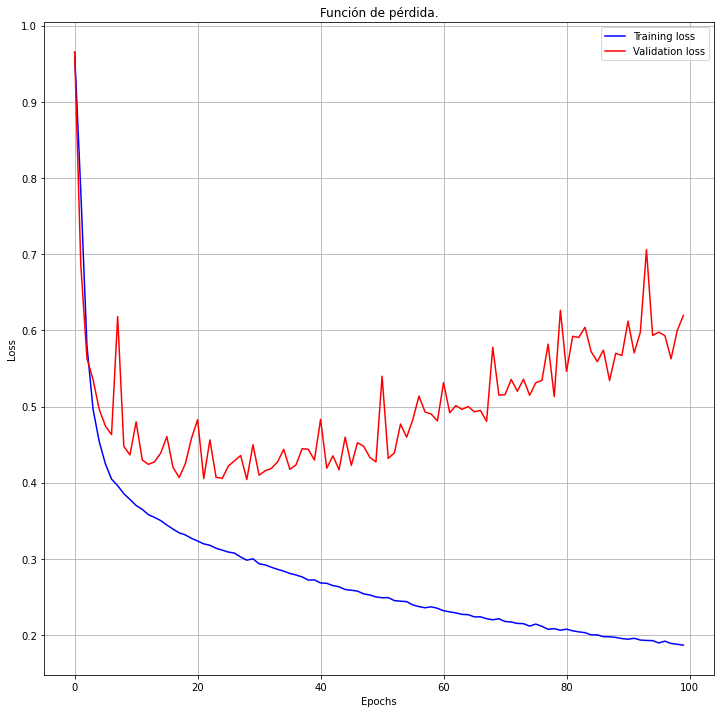

In [40]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, 'Función de pérdida.')

In [41]:
i=0
for batch in LSTM_test:
  if i==5:
    INP , LABS = batch
  i+=1

In [42]:
modelo06 = k.models.load_model('./AirTime06.h5')
# x_o = INPUT.numpy()[24,0,:]
y_o = LABS.numpy()[:,:,0]
y_predict = modelo06.predict(INPUT)[:,:]


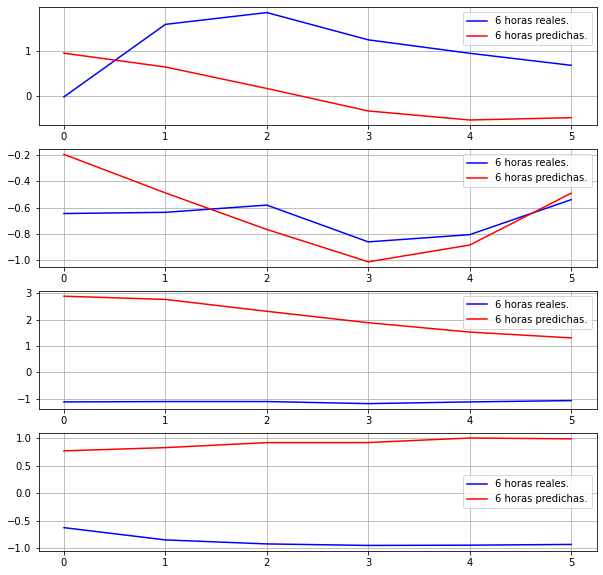

In [43]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(y_o[0], 'b', label='6 horas reales.')
a1.plot(y_predict[0],'r', label='6 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(y_o[1], 'b', label='6 horas reales.')
a2.plot(y_predict[1],'r', label='6 horas predichas.')
a2.legend()
a3 = fig.add_subplot(413)
a3.plot(y_o[2], 'b', label='6 horas reales.')
a3.plot(y_predict[2],'r', label='6 horas predichas.')
a3.legend()
a4 = fig.add_subplot(414)
a4.plot(y_o[3], 'b', label='6 horas reales.')
a4.plot(y_predict[3],'r', label='6 horas predichas.')
a4.legend()

### Prueba para extensión de 10 horas

In [44]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split2_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 10, None])
  return inputs, labels

def make2_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=34,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split2_)

  return ds


LSTM_train2 = make2_dataset(trainset)
LSTM_val2 = make2_dataset(valset)
LSTM_test2 = make2_dataset(testset)

In [45]:
INP2 = []
LAB2 = []
for batch in LSTM_val2:
  INPUT2, LABELS2 = batch
  INP2.append(INPUT2)
  LAB2.append(LABELS2)
print('Label shape: ',np.shape(LAB2),'\n')
print('Input shape: ',np.shape(INP2))

Label shape:  (58,) 

Input shape:  (58,)


In [46]:
import os
time10 = os.getcwd()+'/AirTime10.h5'

In [47]:
AirTime10Net = k.Sequential()
AirTime10Net.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTime10Net.add(LSTM(16, activation='relu', return_sequences=False))
AirTime10Net.add(Dense(16, activation='relu'))
AirTime10Net.add(Dense(10))
my_callbacks = k.callbacks.ModelCheckpoint(
    time10,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
AirTime10Net.compile(optimizer=sgd, loss='mse')

In [48]:
history2 = AirTime10Net.fit(
    LSTM_train2,
    epochs=100,
    validation_data=LSTM_val2,
    callbacks = my_callbacks)

Epoch 1/100
203/203 [==============================] - 7s 34ms/step - loss: 0.9313 - val_loss: 0.9469
Epoch 2/100
203/203 [==============================] - 6s 32ms/step - loss: 0.7906 - val_loss: 0.7979
Epoch 3/100
203/203 [==============================] - 6s 31ms/step - loss: 0.6744 - val_loss: 0.9448
Epoch 4/100
203/203 [==============================] - 6s 29ms/step - loss: 0.5987 - val_loss: 0.6781
Epoch 5/100
203/203 [==============================] - 6s 29ms/step - loss: 0.5482 - val_loss: 0.7666
Epoch 6/100
203/203 [==============================] - 6s 29ms/step - loss: 0.5139 - val_loss: 0.6539
Epoch 7/100
203/203 [==============================] - 6s 30ms/step - loss: 0.4837 - val_loss: 0.6533
Epoch 8/100
203/203 [==============================] - 6s 31ms/step - loss: 0.4666 - val_loss: 0.6662
Epoch 9/100
203/203 [==============================] - 6s 32ms/step - loss: 0.4471 - val_loss: 0.6540
Epoch 10/100
203/203 [==============================] - 7s 32ms/step - loss: 0.431

203/203 [==============================] - 5s 26ms/step - loss: 0.2116 - val_loss: 0.7517
Epoch 81/100
203/203 [==============================] - 5s 26ms/step - loss: 0.2116 - val_loss: 0.8009
Epoch 82/100
203/203 [==============================] - 5s 27ms/step - loss: 0.2098 - val_loss: 0.7820
Epoch 83/100
203/203 [==============================] - 5s 25ms/step - loss: 0.2088 - val_loss: 0.8053
Epoch 84/100
203/203 [==============================] - 5s 26ms/step - loss: 0.2050 - val_loss: 0.8296
Epoch 85/100
203/203 [==============================] - 5s 26ms/step - loss: 0.2070 - val_loss: 0.7888
Epoch 86/100
203/203 [==============================] - 5s 27ms/step - loss: 0.2059 - val_loss: 0.7693
Epoch 87/100
203/203 [==============================] - 5s 26ms/step - loss: 0.2040 - val_loss: 0.8188
Epoch 88/100
203/203 [==============================] - 6s 29ms/step - loss: 0.2027 - val_loss: 0.8200
Epoch 89/100
203/203 [==============================] - 5s 24ms/step - loss: 0.1994 - 

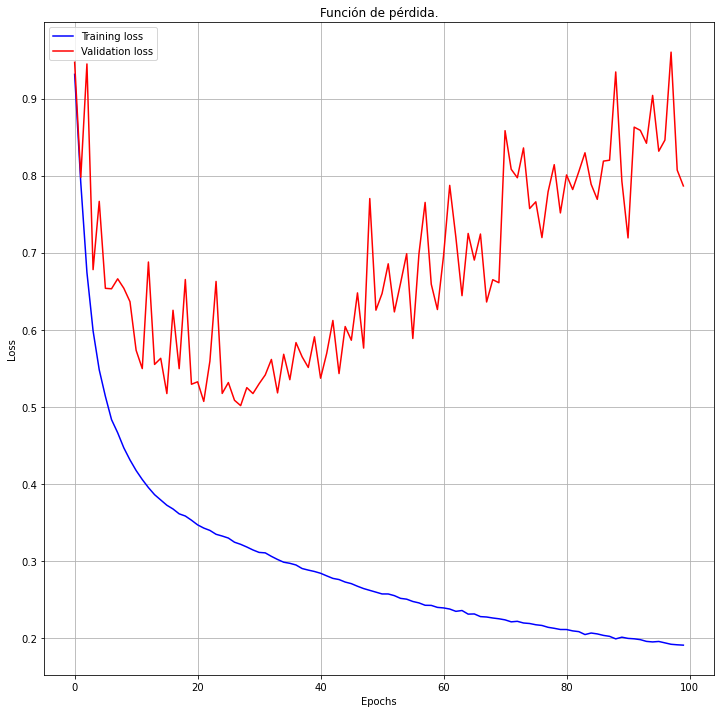

In [49]:
visualize_loss(history2, 'Función de pérdida.')

In [50]:
modelo10 = k.models.load_model('./AirTime10.h5')
# x_o = INPUT.numpy()[24,0,:]
y2_o = LABELS2.numpy()[1:,:,0]
y2_predict = modelo10.predict(INPUT2)[1:,:]



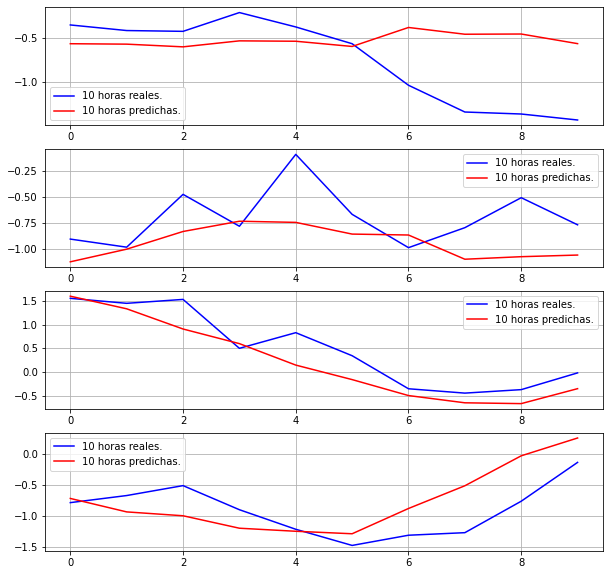

In [51]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(y2_o[0], 'b', label='10 horas reales.')
a1.plot(y2_predict[0],'r', label='10 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(y2_o[1], 'b', label='10 horas reales.')
a2.plot(y2_predict[1],'r', label='10 horas predichas.')
a2.legend()
a3 = fig.add_subplot(413)
a3.plot(y2_o[2], 'b', label='10 horas reales.')
a3.plot(y2_predict[2],'r', label='10 horas predichas.')
a3.legend()
a4 = fig.add_subplot(414)
a4.plot(y2_o[3], 'b', label='10 horas reales.')
a4.plot(y2_predict[3],'r', label='10 horas predichas.')
a4.legend()

### Modelo a 1 hora

In [55]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 1, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=25,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train1 = make_dataset(trainset)
LSTM_val1 = make_dataset(valset)
LSTM_test1 = make_dataset(testset)

In [56]:
time_1 = os.getcwd()+'/AirTime01.h5'
AirTimeNet = k.Sequential()
AirTimeNet.add(LSTM(32, activation='sigmoid', return_sequences=True))
AirTimeNet.add(LSTM(16, activation='relu', return_sequences=False))
AirTimeNet.add(Dense(16, activation='relu'))
AirTimeNet.add(Dense(1))
my_callbacks = k.callbacks.ModelCheckpoint(
    time_1,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)
AirTimeNet.compile(optimizer=sgd, loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

In [57]:
history01 = AirTimeNet.fit(
    LSTM_train1,
    epochs=100,
    validation_data=LSTM_val1,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 7s 33ms/step - loss: 0.3521 - mean_absolute_error: 0.4344 - val_loss: 0.2677 - val_mean_absolute_error: 0.3926
Epoch 2/100
203/203 [==============================] - 6s 31ms/step - loss: 0.1784 - mean_absolute_error: 0.3159 - val_loss: 0.1675 - val_mean_absolute_error: 0.3006
Epoch 3/100
203/203 [==============================] - 7s 33ms/step - loss: 0.1575 - mean_absolute_error: 0.2934 - val_loss: 0.2128 - val_mean_absolute_error: 0.3413
Epoch 4/100
203/203 [==============================] - 6s 31ms/step - loss: 0.1480 - mean_absolute_error: 0.2857 - val_loss: 0.1896 - val_mean_absolute_error: 0.3184
Epoch 5/100
203/203 [==============================] - 6s 29ms/step - loss: 0.1440 - mean_absolute_error: 0.2805 - val_loss: 0.1588 - val_mean_absolute_error: 0.2930
Epoch 6/100
203/203 [==============================] - 6s 30ms/step - loss: 0.1386 - mean_absolute_error: 0.2745 - val_loss: 0.1529 - val_mean_absolute_error: 0.2858
Epoc

203/203 [==============================] - 5s 27ms/step - loss: 0.1026 - mean_absolute_error: 0.2386 - val_loss: 0.1822 - val_mean_absolute_error: 0.3084
Epoch 51/100
203/203 [==============================] - 6s 27ms/step - loss: 0.1029 - mean_absolute_error: 0.2389 - val_loss: 0.1683 - val_mean_absolute_error: 0.2979
Epoch 52/100
203/203 [==============================] - 6s 29ms/step - loss: 0.1011 - mean_absolute_error: 0.2365 - val_loss: 0.1609 - val_mean_absolute_error: 0.2901
Epoch 53/100
203/203 [==============================] - 5s 26ms/step - loss: 0.1019 - mean_absolute_error: 0.2377 - val_loss: 0.1662 - val_mean_absolute_error: 0.2942
Epoch 54/100
203/203 [==============================] - 6s 32ms/step - loss: 0.1004 - mean_absolute_error: 0.2370 - val_loss: 0.1762 - val_mean_absolute_error: 0.3080
Epoch 55/100
203/203 [==============================] - 6s 30ms/step - loss: 0.0996 - mean_absolute_error: 0.2347 - val_loss: 0.1714 - val_mean_absolute_error: 0.3018
Epoch 56/10

203/203 [==============================] - 5s 26ms/step - loss: 0.0792 - mean_absolute_error: 0.2126 - val_loss: 0.2287 - val_mean_absolute_error: 0.3438
Epoch 100/100
203/203 [==============================] - 5s 25ms/step - loss: 0.0782 - mean_absolute_error: 0.2113 - val_loss: 0.2031 - val_mean_absolute_error: 0.3250


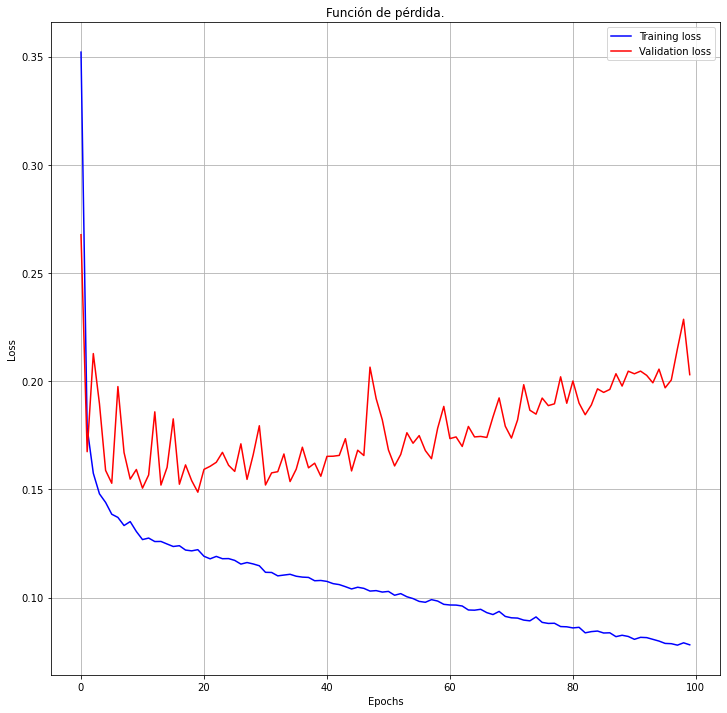

In [58]:
visualize_loss(history01, 'Función de pérdida.')

In [59]:
modelo01 = k.models.load_model('./AirTime01.h5')
pred01 = []
labs01 = []
for batch in LSTM_test1:
  IN01 , LAB01 = batch
  LABPRED = modelo01.predict(IN01)
  for i in range(11):
    labs01.append(LAB01.numpy()[:,0,0][i])
  for i in range(11):
    pred01.append(LABPRED[:,0][i])

In [60]:
len(pred01)

319

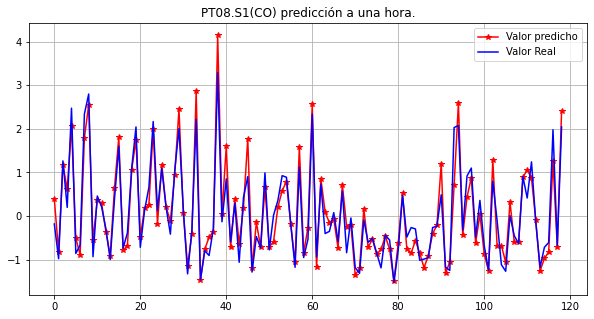

In [62]:
plt.figure(figsize=(10,5))
plt.plot(pred01[100:-100],'r*-', color ='r',label='Valor predicho')
plt.plot(labs01[100:-100],'b',label='Valor Real')
plt.legend()
plt.title('PT08.S1(CO) predicción a una hora.')
plt.savefig('Modelo_h1_test.pdf')

#### Recuperar errores del modelo con conjunto test

In [63]:
errores1hr = modelo01.evaluate(LSTM_train1)
print(errores1hr)

203/203 [==============================] - 2s 10ms/step - loss: 0.1122 - mean_absolute_error: 0.2479
[0.11217404156923294, 0.24789190292358398]


In [65]:
MSE1hr_train = (std[0]**2)*errores1hr[0]
print('El error cuadratico medio para conjunto train es de: ',MSE1hr_train)

El error cuadratico medio para conjunto train es de:  5350.306743769993


In [69]:
MAE1hr_train = std[0]*errores1hr[1]
print('El error absoluto medio para el conjunto train es de: ', MAE1hr_train)

El error absoluto medio para el conjunto train es de:  54.13841020465742


In [67]:
errores1hrTest = modelo01.evaluate(LSTM_test1)
errores1hrTest

29/29 [==============================] - 0s 8ms/step - loss: 0.0984 - mean_absolute_error: 0.2316


[0.09837789833545685, 0.23159259557724]

In [68]:
MSE1hr_test = (std[0]**2)*errores1hrTest[0]
print('El error cuadratico medio para conjunto test es de: ',MSE1hr_test)

El error cuadratico medio para conjunto test es de:  4692.2792968750555


In [70]:
MAE1hr_test = std[0]*errores1hrTest[1]
print('El error absoluto medio para el conjunto test es de: ', MAE1hr_test)

El error absoluto medio para el conjunto test es de:  50.57871915883825


### Modelo para 24 horas

In [71]:
indice_columnas = {str(name): i for i, name in enumerate(trainset.columns)}


def split_(features):
  inputs = features[:, slice(0,24), :]
  labels = features[:, slice(24,None), :]
  labels = tf.stack([labels[:, :, indice_columnas[name]] for name in ['PT08.S1(CO)']],axis=-1)
  inputs.set_shape([None, 24, None])
  labels.set_shape([None, 24, None])
  return inputs, labels

def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=48,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(split_)

  return ds


LSTM_train24 = make_dataset(trainset)
LSTM_val24 = make_dataset(valset)
LSTM_test24 = make_dataset(testset)

In [72]:
time_24 = os.getcwd()+'/AirTime24.h5'
AirTimeNet = k.Sequential()
AirTimeNet.add(LSTM(64, activation='sigmoid', return_sequences=True))
AirTimeNet.add(LSTM(32, activation='relu', return_sequences=False))
AirTimeNet.add(Dense(64, activation='relu'))
AirTimeNet.add(Dense(24))
my_callbacks = k.callbacks.ModelCheckpoint(
    time_24,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)
sgd = k.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.5, nesterov=True)
AirTimeNet.compile(optimizer=sgd, loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

In [73]:
history01 = AirTimeNet.fit(
    LSTM_train24,
    epochs=100,
    validation_data=LSTM_val24,
    callbacks = [my_callbacks])

Epoch 1/100
203/203 [==============================] - 9s 45ms/step - loss: 0.8493 - mean_absolute_error: 0.7279 - val_loss: 1.2434 - val_mean_absolute_error: 0.8681
Epoch 2/100
203/203 [==============================] - 7s 35ms/step - loss: 0.6801 - mean_absolute_error: 0.6447 - val_loss: 0.7377 - val_mean_absolute_error: 0.6869
Epoch 3/100
203/203 [==============================] - 7s 35ms/step - loss: 0.5466 - mean_absolute_error: 0.5655 - val_loss: 0.6476 - val_mean_absolute_error: 0.6133
Epoch 4/100
203/203 [==============================] - 7s 35ms/step - loss: 0.4868 - mean_absolute_error: 0.5285 - val_loss: 0.7041 - val_mean_absolute_error: 0.6564
Epoch 5/100
203/203 [==============================] - 8s 37ms/step - loss: 0.4670 - mean_absolute_error: 0.5162 - val_loss: 0.6433 - val_mean_absolute_error: 0.6185
Epoch 6/100
203/203 [==============================] - 7s 33ms/step - loss: 0.4485 - mean_absolute_error: 0.5038 - val_loss: 0.6555 - val_mean_absolute_error: 0.6226
Epoc

203/203 [==============================] - 6s 30ms/step - loss: 0.2115 - mean_absolute_error: 0.3507 - val_loss: 0.8723 - val_mean_absolute_error: 0.7248
Epoch 51/100
203/203 [==============================] - 7s 34ms/step - loss: 0.2063 - mean_absolute_error: 0.3474 - val_loss: 0.8897 - val_mean_absolute_error: 0.7241
Epoch 52/100
203/203 [==============================] - 7s 32ms/step - loss: 0.2070 - mean_absolute_error: 0.3471 - val_loss: 1.0874 - val_mean_absolute_error: 0.8012
Epoch 53/100
203/203 [==============================] - 6s 31ms/step - loss: 0.2013 - mean_absolute_error: 0.3427 - val_loss: 1.1762 - val_mean_absolute_error: 0.8566
Epoch 54/100
203/203 [==============================] - 7s 33ms/step - loss: 0.2036 - mean_absolute_error: 0.3443 - val_loss: 0.8918 - val_mean_absolute_error: 0.7253
Epoch 55/100
203/203 [==============================] - 6s 32ms/step - loss: 0.2007 - mean_absolute_error: 0.3417 - val_loss: 0.9604 - val_mean_absolute_error: 0.7481
Epoch 56/10

203/203 [==============================] - 6s 29ms/step - loss: 0.1414 - mean_absolute_error: 0.2869 - val_loss: 1.2688 - val_mean_absolute_error: 0.8842
Epoch 100/100
203/203 [==============================] - 6s 30ms/step - loss: 0.1383 - mean_absolute_error: 0.2839 - val_loss: 1.1464 - val_mean_absolute_error: 0.8269


In [74]:
modelo24 = k.models.load_model('./AirTime24.h5')

#### Errores modelo de 24 horas.

In [75]:
error24train = modelo24.evaluate(LSTM_train24)

203/203 [==============================] - 3s 13ms/step - loss: 0.4172 - mean_absolute_error: 0.4753


In [76]:
MSE24train = error24train[0]*std[0]**2
print('El error cuadrático medio para el conjunto train es de: ', MSE24train)

El error cuadrático medio para el conjunto train es de:  19899.859135456216


In [77]:
MAE24train = error24train[1]*std[0]
print('El error absoluto medio para el conjunto train es de: ',MAE24train)

El error absoluto medio para el conjunto train es de:  103.80467027960964


In [78]:
error24test = modelo24.evaluate(LSTM_test24)

28/28 [==============================] - 0s 10ms/step - loss: 0.3761 - mean_absolute_error: 0.4753


In [79]:
MSEtest = error24test[0]*std[0]**2
print('El error cuadrático medio para el conjunto test es de: ', MSEtest)

El error cuadrático medio para el conjunto test es de:  17940.391240276258


In [80]:
MAEtest = error24test[1]*std[0]
print('El error absoluto medio para el conjunto test es de: ', MAEtest)

El error absoluto medio para el conjunto test es de:  103.8042862671841


In [81]:
Batches24 = []
for bat in LSTM_test24.as_numpy_iterator():
  Batches24.append(bat)

In [82]:
Batches24 = np.array(Batches24)

In [83]:
YPRED = []
YREAL = []
for i in range(32):
  y24_pred = modelo24.predict(Batches24[0,0])[i,:]
  y24_real = Batches24[0,1][i,:,0]
  for x0 in y24_pred:
    YPRED.append(x0)
  for x1 in y24_real:
    YREAL.append(x1)


len(YPRED)==len(YREAL)

True

Text(0.5, 1.0, 'Comparación predicción función test.')

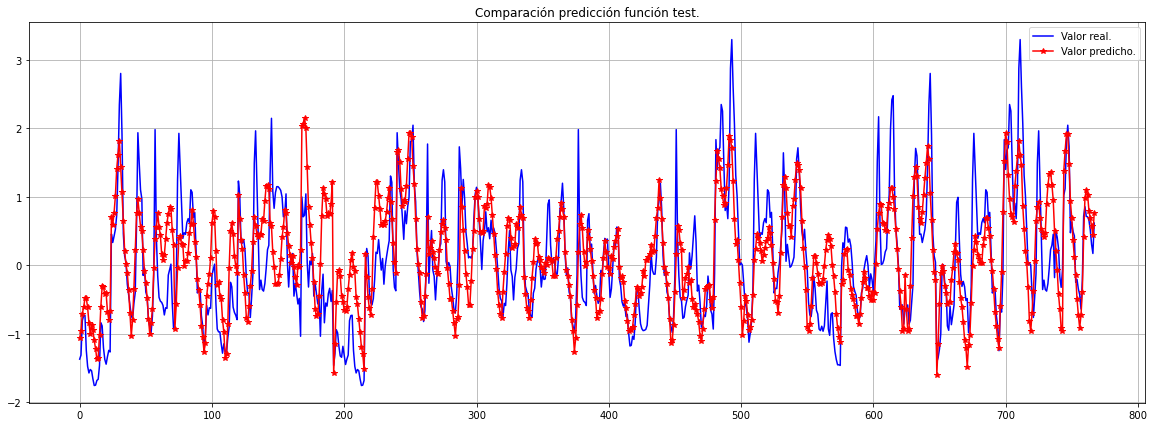

In [84]:
plt.figure(figsize=(20,7))
plt.plot(YREAL,'b',label='Valor real.')
plt.plot(YPRED,'*-r',label='Valor predicho.')
plt.legend()
plt.title('Comparación predicción función test.')

In [85]:
p24 = modelo24.predict(Batches24[2,0])
lab24 = Batches24[2,1][:,:,0]
lab24.shape

(32, 24)

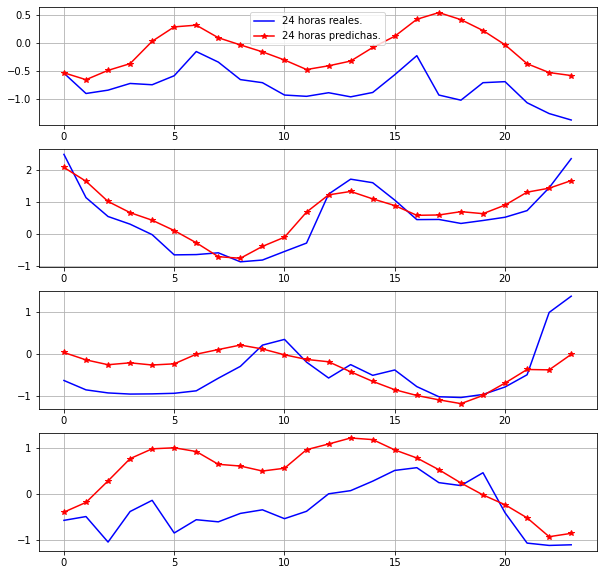

In [86]:
fig = plt.figure(figsize=(10,10))
a1 = fig.add_subplot(411)
a1.plot(lab24[0,:], 'b', label='24 horas reales.')
a1.plot(p24[0,:],'*-',color='r', label='24 horas predichas.')
a1.legend()
a2 = fig.add_subplot(412)
a2.plot(lab24[3,:], 'b', label='24 horas reales.')
a2.plot(p24[3,:],'*-',color='r', label='24 horas predichas.')

a3 = fig.add_subplot(413)
a3.plot(lab24[15,:], 'b', label='24 horas reales.')
a3.plot(p24[15,:],'*-',color='r', label='24 horas predichas.')

a4 = fig.add_subplot(414)
a4.plot(lab24[27,:], 'b', label='24 horas reales.')
a4.plot(p24[27,:],'*-',color='r', label='24 horas predichas.')
